# Pan-cancer (PC) plasma proteome Paper — Figure 8

This Jupyter Notebook (with Python 3 kernel) contained the code for machine learning model evaluation.

Output figures:  
* Figure S11a, S11b, 8b, 8c, 8d, 8e, 8f, 8g

In [5]:
from utils import *
paths = ['../figure/figure8', '../documents/figure8']
for path in paths:
    if not os.path.isdir(path):
        os.makedirs(path)

a = Analysis('../')

palette = {'CRCA': '#636efa', 'ESCA': '#19D3F3', 'STAD': '#FF6692', 'BRCA': '#00CC96', 'TGCT': '#FFCCDB', 'LC': '#FECB52', 'RCC': '#FFDBC0', 'BLCA': '#EF553B', 'ML': '#C6CAFD'}
tumor_types = ['LC', 'ML', 'CRCA', 'ESCA', 'BLCA', 'RCC']

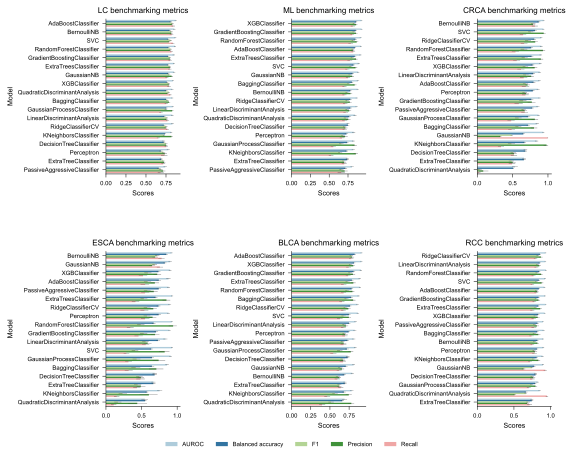

In [2]:
from utils.function import sort_custom

fig, axs = plt.subplots(2, 3, figsize=(8, 7))
plt.subplots_adjust(wspace=1.5, hspace=.5)

path = '../documents/figure8/binary/benchmark'
combine = pd.DataFrame()
for i, tumor_type in enumerate(tumor_types):
    benchmark_path = os.path.join(path, f'binary_{tumor_type}_model_benchmarking_result.csv')
    df = pd.read_csv(benchmark_path, index_col=0).iloc[:, 2:].set_index('model').rename_axis('Model').rename_axis('Metrics', axis=1).stack().rename('Scores')

    order_1 = ['test_roc_auc', 'test_balanced_accuracy', 'test_f1', 'test_precision', 'test_recall']
    df = sort_custom(df.reset_index(), 'Metrics', order_1).replace(order_1, ['AUROC', 'Balanced accuracy', 'F1', 'Precision', 'Recall'])

    order_ = df.groupby('Model')['Scores'].mean().sort_values(ascending=False).index
    df = sort_custom(df, 'Model', order_)
    combine = pd.concat([combine, df.assign(tumor_type=tumor_type).groupby(['tumor_type', 'Model', 'Metrics']).agg(['mean', 'std'])])

    ax = axs.ravel()[i]
    barplot(df, dodge=True, orient='h', ticklabels_wrap=[], ticklabels_format=[], ticklabels_hide=[], ax=ax, palette=MCMAP[:5], errwidth=.3, title='{} benchmarking metrics'.format(tumor_type))
    if i != 4:
        ax.get_legend().remove()
    else:
        ax.legend(loc="lower center", bbox_to_anchor=(0, -.3), frameon=False, ncol=5)
fig.savefig('../figure/figure8/FigS11a.pdf', bbox_inches='tight')

In [2]:
ml_binary = ML_model('../documents/figure8', model_type='binary')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

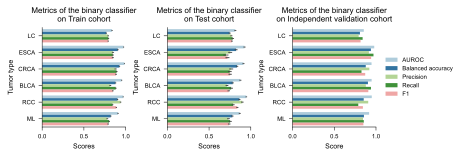

In [3]:
ml_binary.evaluate_model_performance(cohort=['discovery', 'validation'])
ml_binary.train_test_scores_df.to_csv('../documents/figure8/binary/binary_bootstrap_refitting_model_metrics.csv')
ml_binary.validation_scores_df.to_csv('../documents/figure8/binary/binary_refitting_validation_metrics.csv')

fig, axs = plt.subplots(1, 3, figsize=(6, 1.8))
plt.subplots_adjust(wspace=.5)
for ax in axs.ravel():
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([0.0, 0.5, 1.0])

for i, cohort, ax in zip([0, 1], ['train', 'test'], axs.ravel()[:2]):
    barplot(ml_binary.train_test_scores_df.query("Cohort==@cohort")[['Tumor type', 'Metric', 'Score']], dodge=True, ticklabels_format=[], ticklabels_hide=[], palette=MCMAP[:5], ax=ax, orient='h', title='Metrics of the binary classifier\non {} cohort'.format(cohort.title()))
    ax.set_ylabel('Tumor type')
    ax.set_xlabel('Scores')
    if i != 2:
        ax.get_legend().remove()

ax = barplot(ml_binary.validation_scores_df.drop('Cohort', axis=1)[['Tumor type', 'Metric', 'Score']], dodge=True, orient='h', ticklabels_format=[], ticklabels_hide=[], palette=MCMAP[:5], ax=axs[2], title='Metrics of the binary classifier\non Independent validation cohort')

fig.savefig('../figure/figure8/Fig8b-FigS11b.pdf', bbox_inches='tight')

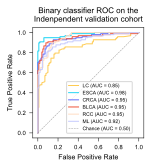

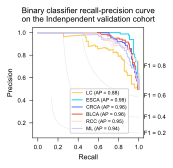

In [5]:
ax = ml_binary.plot_roc(cohort='validation', palette=palette)
ax.get_figure().savefig('../figure/figure8/Fig8c_left-panel.pdf', bbox_inches='tight')

ax = ml_binary.plot_recall_precision_curve(cohort='validation', palette=palette)
ax.get_figure().savefig('../figure/figure8/Fig8c_right-panel.pdf', bbox_inches='tight')


In [6]:
ml_binary.feature_importance(cohorts=['discovery', 'validation'])
ml_binary.fi.to_csv('../documents/figure8/binary/Source_data_Fig8d.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


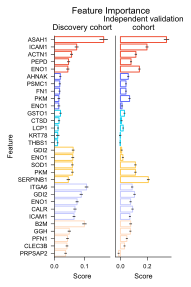

In [7]:
fi = ml_binary.fi.copy()
fi['for_order'] = fi.groupby(['Tumor type', 'Cohort', 'Feature'])['Score'].transform(np.mean)
fi_discovery = fi.query("Cohort=='discovery'")
fi_discovery = fi_discovery.groupby(['Tumor type', 'Cohort'], as_index=False).apply(lambda x: x.sort_values('for_order', ascending=False).iloc[:500]).droplevel(0)
fi_validation = fi.query("Cohort=='validation'")

fig, axs = plt.subplots(1, 2, figsize=(2.1, 4))
plt.subplots_adjust(wspace=.1)
edgecolor = [palette[i] for i in pd.unique(fi_discovery['Tumor type'])]
edgecolor = np.repeat(edgecolor, 5)

plotdata = fi_discovery.set_index('Tumor type', append=True).iloc[:, 0]
plotdata.index = pd.MultiIndex.from_arrays([plotdata.index.get_level_values(0), plotdata.index.map(lambda x: x[2]+'_'+x[1])], names=('Repeat', 'Feature'))
usage = np.array(list(map(lambda x: x.split('_'), pd.unique(plotdata.index.get_level_values(1)))))
ax = barplot(plotdata, orient='h', ticklabels_format=[], ticklabels_hide=[], edgecolor=edgecolor, linewidth=1, color='w', ax=axs[0], title='Discovery cohort')
ax.set_yticklabels(usage[:, 1])

plotdata = fi_validation.reset_index().set_index(['Tumor type', 'Feature']).loc[list(map(lambda x: tuple(x), usage))]
plotdata.index = plotdata.index.map(lambda x: (x[0]+'_'+x[1]))
plotdata = plotdata.rename_axis('Feature').reset_index().loc[:, ['Repeat', 'Feature', 'Score']].set_index('Repeat')
ax = barplot(plotdata, orient='h', ticklabels_format=[], ticklabels_hide=['y'], labels_hide=['y'], edgecolor=edgecolor, linewidth=1, color='w', ax=axs[1], title='Independent validation\ncohort')

plt.suptitle('Feature Importance', fontsize=9)
fig.savefig('../figure/figure8/Fig8d.pdf', bbox_inches='tight')

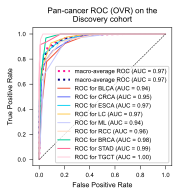

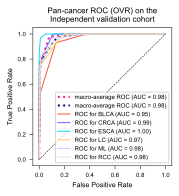

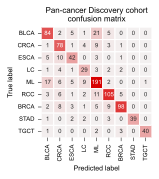

In [8]:
ml_multi = ML_model('../documents/figure8', model_type='multi')
for cohort, save_name in zip(['discovery', 'validation'], ['8e', '8g']):
    ax = ml_multi.plot_multi_roc(cohort=cohort, palette=palette)
    ax.get_figure().savefig(f'../figure/figure8/Fig{save_name}.pdf', bbox_inches='tight')
ax = ml_multi.plot_cm(cohort='discovery')
ax.get_figure().savefig('../figure/figure8/Fig8f.pdf', bbox_inches='tight')

In [9]:
from utils.function import sort_custom
path = '../documents/figure8/binary/benchmark'

combine = pd.DataFrame()
for i, tumor_type in enumerate(tumor_types):
    benchmark_path = os.path.join(path, f'binary_{tumor_type}_model_benchmarking_result.csv')
    df = pd.read_csv(benchmark_path, index_col=0).iloc[:, 2:].set_index('model').rename_axis('Model').rename_axis('Metrics', axis=1).stack().rename('Scores')

    order_1 = ['test_roc_auc', 'test_balanced_accuracy', 'test_f1', 'test_precision', 'test_recall']
    df = sort_custom(df.reset_index(), 'Metrics', order_1).replace(order_1, ['AUROC', 'Balanced accuracy', 'F1', 'Precision', 'Recall'])

    order_ = df.groupby('Model')['Scores'].mean().sort_values(ascending=False).index
    df = sort_custom(df, 'Model', order_)
    combine = pd.concat([combine, df.assign(tumor_type=tumor_type).groupby(['tumor_type', 'Model', 'Metrics']).agg(['mean', 'std'])])
